Using device: cpu
Epoch [1/1], Train Loss: 0.7734, Val Loss: 0.4857
Validation loss decreased (inf --> 0.485671). Saving model...
Best Combination: seq_len: 20, label_len: 4, Val Loss: 0.4857


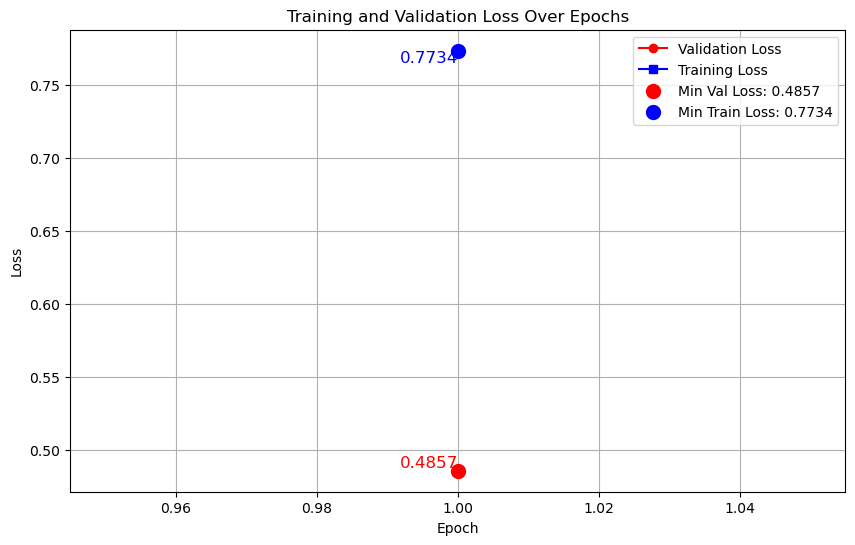

Training with layer config: [4], 4, [4]
Training with learning rate: 0.01


KeyboardInterrupt: 

In [1]:
%run run_new.py 1

In [ ]:
%run real_data_exchange_linux.py 1

In [2]:
%run run.py 2

1.3663152077340701
